In [15]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyBigWig
import cooler
import cooltools
import coolpuppy
import gseapy as gp
import pingouin as pg
import bioframe as bf

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_venn import venn2, venn3, venn2_circles, venn3_circles

In [2]:
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Практика: мультиомиксный подход к анализу петель

> Задача: построить среднюю петлю для топ-50 o измененных между нейронами и глией петель и построить профили ChIP-seq CTCF и H3K27me3 в основаниях этих петель

## 1. Готовим петли

### Читаем данные

In [4]:
RES = 10_000

clr_path = {
    'NeuN+': "human_data/NeuNplus.sampled.1000.mcool",
    'NeuN-': "human_data/NeuNminus.sampled.1000.mcool"
}

clrs = {ct:
    cooler.Cooler(clr_path[ct] + f'::resolutions/{RES}') 
    for ct in ('NeuN+', 'NeuN-')}

In [5]:
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens = bf.fetch_centromeres('hg38')
hg38_arms = bf.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = hg38_arms.set_index("chrom").loc[clrs['NeuN+'].chromnames].reset_index()

### Размечаем петли как в `HiC_Practice_II.ipynb`

In [6]:
%%time 

## Ячейка бежит около 10 минут в 2 потока!

loops = {}
expected = {}
for ct, clr in clrs.items():
    print(ct, 'Expected')
    expected[ct] = cooltools.expected_cis(clr, view_df=hg38_arms, nproc=2)
    print(ct, 'Dots')
    loops[ct] = cooltools.dots(
                             clr, expected=expected[ct], view_df=hg38_arms,
                             max_loci_separation=10_000_000, nproc=2,
                            )

NeuN+ Expected
NeuN+ Dots
NeuN- Expected
NeuN- Dots
CPU times: user 50.9 s, sys: 20.4 s, total: 1min 11s
Wall time: 3min 46s


### Готовим топ-50 измененных петель

In [127]:
loops['NeuN+'].shape, loops['NeuN-'].shape

((3031, 22), (3332, 22))

In [191]:
coords_cols = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
top_changed_dots = pd.merge(loops['NeuN+'], loops['NeuN-'], 
                             how='inner', on=coords_cols) \
                            .set_index(coords_cols) \
                            .apply(lambda x: x['la_exp.donut.value_x'] / x['la_exp.donut.value_y'] , axis=1) \
                            .nlargest(50).index.to_list()

top_changed_dots_df = pd.DataFrame(top_changed_dots, columns=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2'])
top_changed_dots_df['strand1'] = '+'
top_changed_dots_df['strand2'] = '+'

In [192]:
top_changed_dots_df.head(3)

,chrom1,start1,end1,chrom2,start2,end2,strand1,strand2
0,chr10,132220000,132230000,chr10,132450000,132460000,+,+
1,chr9,17530000,17540000,chr9,17800000,17810000,+,+
2,chr5,175530000,175540000,chr5,175710000,175720000,+,+


### Считаем усредненную петлю

In [193]:
%%time 

FLANK = 200_000
pileups = {}
for ct, clr in clrs.items():
    stack = cooltools.pileup(clr, top_changed_dots_df, 
                             view_df=hg38_arms, expected_df=expected[ct], 
                             flank=FLANK)
    
    pileups[ct] = np.nanmean(stack, axis=0)

CPU times: user 48 s, sys: 639 ms, total: 48.7 s
Wall time: 48.8 s


## Готовим ChIP-seq в основаниях петель

Для примера возьмем следующие данные ChIP-seq за H3K27me3 с сайта ENCODE: [ENCFF730MML](https://www.encodeproject.org/experiments/ENCSR472SEY/) (нейроны) и [ENCFF036FSG](https://www.encodeproject.org/experiments/ENCSR000AOR/) (астроциты)

```bash
wget https://www.encodeproject.org/files/ENCFF730MML/@@download/ENCFF730MML.bigWig -O ./human_data/H3K27me3_neuro.bigWig
wget https://www.encodeproject.org/files/ENCFF036FSG/@@download/ENCFF036FSG.bigWig -O ./human_data/H3K27me3_astro.bigWig
```

Для примера возьмем следующие данные ChIP-seq за CTCF с сайта ENCODE: [ENCFF176LVN](https://www.encodeproject.org/experiments/ENCSR619IUE/) (нейроны) и [ENCFF341CMJ](https://www.encodeproject.org/experiments/ENCSR000AOO/) (астроциты)

```bash
wget https://www.encodeproject.org/files/ENCFF176LVN/@@download/ENCFF176LVN.bigWig -O ./human_data/CTCF_neuro.bigWig 
wget https://www.encodeproject.org/files/ENCFF341CMJ/@@download/ENCFF341CMJ.bigWig -O ./human_data/CTCF_astro.bigWig
````

### Отбираем основания петель

In [194]:
anchors = pd.DataFrame(set([dot[:3] for dot in top_changed_dots] + [dot[3:] for dot in top_changed_dots]), columns=['chrom', 'start', 'end'])

In [195]:
anchors['center'] = (anchors['end'] + anchors['start'])//2

In [196]:
print(anchors.shape)
anchors.head(3)

(99, 4)


,chrom,start,end,center
0,chr11,82690000,82700000,82695000
1,chr2,232850000,232860000,232855000
2,chr5,153960000,153970000,153965000


### Читаем сигналы ChIP-seq и выделяем значения вокруг пиков

In [197]:
bw_files = {
            'CTCF': {
                'NeuN+': './human_data/CTCF_neuro.bigWig',
                'NeuN-': './human_data/CTCF_astro.bigWig'
            },
            'H3K27me3': {
                'NeuN+': './human_data/H3K27me3_neuro.bigWig',
                'NeuN-': './human_data/H3K27me3_astro.bigWig'
            }
}

In [198]:
bws = {}
ctcf_dot_signal = {}
for mark in bw_files:
    bws[mark] = {}
    ctcf_dot_signal[mark] = {}
    
    for ct in clrs:
            bws[mark][ct] = pyBigWig.open(bw_files[mark][ct])  
            signal = anchors.apply(lambda x: 
                                        bws[mark][ct].values(x.chrom, 
                                                             x.center - FLANK, 
                                                             x.center + FLANK), 
                                   axis=1)
            ctcf_dot_signal[mark][ct] = pd.DataFrame(np.array(signal.to_list()), index=anchors.index)

### Усредним ChIP-seq чтобы чуть быстрее рисовалось

In [206]:
ctcf_dot_signal_averaged = {}
for mark in bw_files:
    ctcf_dot_signal_averaged[mark] = {}
    
    for ct in clrs:
        ncols = len(ctcf_dot_signal[mark][ct].columns)
        cols_groups = np.arange(ncols) // 500
        df = ctcf_dot_signal[mark][ct].groupby(cols_groups, axis=1).mean()

        # упорядочим строки по возрастанию среднего сигнала
        df['Mean'] = df.mean(axis=1)
        df_sorted = df.sort_values(by='Mean', ascending=False)
        df_sorted = df_sorted.drop('Mean', axis=1)
    
        ctcf_dot_signal_averaged[mark][ct] = df_sorted

In [207]:
def y_axis_formatter(x, pos):
    pos = (x * RES - FLANK)/10**3
    return '{:.0f} Kb'.format(pos) if pos != 0 else  'Peak center'

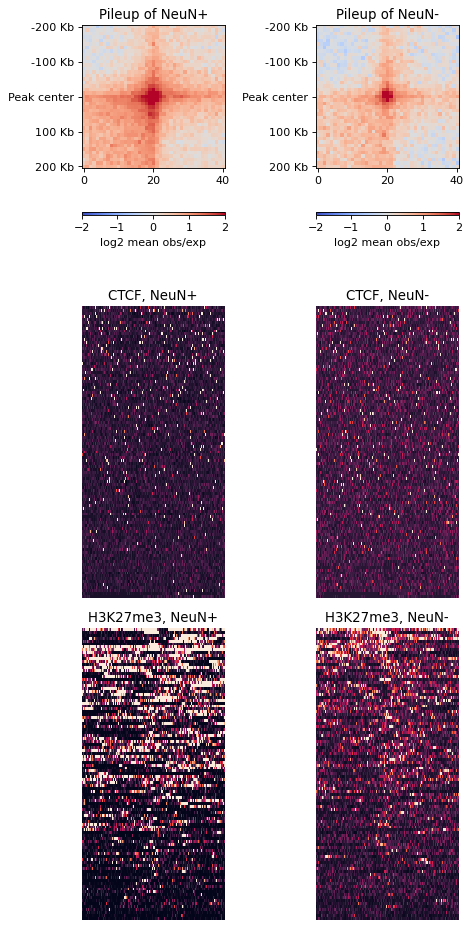

In [261]:
fig, axs = plt.subplots(ncols=2, nrows=3, 
                        sharex = False,
                        figsize=(6, 12), dpi=80, 
                        layout='tight')

for i, (ct, mtx) in enumerate(pileups.items()):
    ax = axs[0][i]
    im = ax.imshow(np.log2(mtx),
        vmax = 2, vmin = -2,
        cmap='coolwarm')

    ax.set_title(f'Pileup of {ct}')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(y_axis_formatter))
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("bottom", size="30%", pad=0.3, aspect=0.1)
    plt.colorbar(im, cax=cax, label = 'log2 mean obs/exp', orientation='horizontal')

    for j, mark in enumerate(bw_files):
        ax = axs[j+1][i]
        v = 2
        
        sns.heatmap(ctcf_dot_signal_averaged[mark][ct],
                    xticklabels=False,
                    yticklabels=False, 
                    vmin=0, vmax=+v,
                    cbar=False,
                    ax=ax
                   )
        ax.set_ylabel('')
        ax.set_title(f'{mark}, {ct}')
        